In [58]:
import sys; sys.path.append("../scripts/")
import pandas as pd
import numpy as np
from numpy import nan
from matplotlib import style, pyplot as plt
import seaborn as sns
from load_data import user_artist_df, artist_mean_rate
from collaborative_filtering import Collaborative_Filtering
predict_txt = "../data/ratings.csv"
from itable import *
from IPython.display import IFrame, Image, HTML, display
import pickle

style.use("ggplot")
%matplotlib notebook

# *Machine Learning*
### for Actuaries
![](https://d3njjcbhbojbot.cloudfront.net/api/utilities/v1/imageproxy/https://coursera.s3.amazonaws.com/topics/ml/large-icon.png)

### Machine Learning 
>"Field of study that gives computers the ability to learn without being explicitly programmed". -Arthur Samuel, 1959

In [83]:
Image(url="./k_learn.gif", width=600, height=600)

## Recommender Systems
#### Collaborative Filtering

In [2]:
movies = ["love1", "love2", "love3", "action1", "action2"]
users = {"Alice":[5, 5, nan, 0, 0],
         "Elizabeth":[5, nan, 4, 0, 0],
         "Wolfgang":[0, 0, nan, 5, nan],
         "Andreas": [0, nan, 0, 5, 5]}

degrees = {"1love":   [0.9, 1, 0.98, 0.01, 0],
           "2action": [0, 0, 0.1, 0.92, 1]}

In [3]:
users = pd.DataFrame(users, index=movies)
degrees = pd.DataFrame(degrees, index = movies)
table = users.join(degrees)

pt = PrettyTable(table, tstyle=TableStyle(theme="theme1"), center=True, header_row=True)
cs1, cs2 = CellStyle(), CellStyle()
cs1.set("background-color", "#add")
cs2.set("background-color", "#faa")
pt.set_cell_style(style=cs1, cols=[4,5])
pt.set_cell_style(style=cs2, rows=[2], cols=[0])

In [9]:
pt

,Alice,Andreas,Elizabeth,Wolfgang,1love,2action
love1,5.0,0.0,5.0,0.0,0.9,0.0
love2,5.0,nan,nan,0.0,1.0,0.0
love3,nan,0.0,4.0,nan,0.98,0.1
action1,0.0,5.0,0.0,5.0,0.01,0.92
action2,0.0,5.0,0.0,nan,0.0,1.0


Denote

* $Y^{(i,j)}$: the rate on movie $i$, given by user $j$
* $X^{i}$: parameters for movie $i$
* $\theta^{j}$: parameters for user $j$
* $n_u$: Number users
* $n_m$: Number movies
* $p$: Number parameters

We would like to find $\theta^{j}$ such that:

$$
    (\theta^j)^T \bullet X^i \approx Y^{(i,j)}
$$
i.e.
$$
    \theta^T X \approx Y 
$$

$X \in \mathbb{R}^{p \times n_m}$, $\theta\in\mathbb{R}^{p \times n_u}$

In [10]:
x_love3 = degrees.ix["love3"].values
x_love3 = np.append(1, x_love3)
x_love3.shape = (3,1)

# Somehow Learned
theta_alice = np.array([[0, 5, 0]]).T

np.dot(theta_alice.T, x_love3)

array([[ 4.9]])

In [11]:
pred_u = users.copy(); pred_u.ix["love3", "Alice"] = 4.9
pt2 = PrettyTable(pred_u, tstyle=TableStyle(theme="theme1"), center=True, header_row=True)
cs, cs3 = CellStyle(), CellStyle()
cs.set("background-color", "#faa")
cs3.set("background-color", "#ddd")
pt2.set_cell_style(style=cs, rows=[2], cols=[0])
pt2.set_cell_style(style=cs3, rows=[1,1], cols=[1,2])
pt2.set_cell_style(style=cs3, rows=[2], cols=[3])
pt2.set_cell_style(style=cs3, rows=[4], cols=[3])

In [12]:
pt2

,Alice,Andreas,Elizabeth,Wolfgang
love1,5.0,0.0,5.0,0.0
love2,5.0,nan,nan,0.0
love3,4.9,0.0,4.0,nan
action1,0.0,5.0,0.0,5.0
action2,0.0,5.0,0.0,nan


given:
$$
\{X^{(1)}, \ldots, X^{(n_m)}\} \underset{learn}{\rightarrow} \{\theta^{(1)}, \ldots, \theta^{(n_u)}\}
$$

* What if $\{X^{(i)}\}_{i=1}^{n_m}$ is unknown?
* What is the size of $p$?

In [13]:
degrees = {"1love":   np.repeat("?",5),
           "2action": np.repeat("?",5)}
degrees = pd.DataFrame(degrees, index = movies)
table2 = users.join(degrees)

pt_ukn = PrettyTable(table2, tstyle=TableStyle(theme="theme1"), center=True, header_row=True)
cs1 = CellStyle()
cs1.set("background-color", "#add")
pt_ukn.set_cell_style(style=cs1, cols=[4,5])

In [14]:
pt_ukn

,Alice,Andreas,Elizabeth,Wolfgang,1love,2action
love1,5.0,0.0,5.0,0.0,?,?
love2,5.0,nan,nan,0.0,?,?
love3,nan,0.0,4.0,nan,?,?
action1,0.0,5.0,0.0,5.0,?,?
action2,0.0,5.0,0.0,nan,?,?


## The data: [Yahoo! Webscope dataset](http://research.yahoo.com/Academic_Relations)

<IPython.core.display.Javascript object>


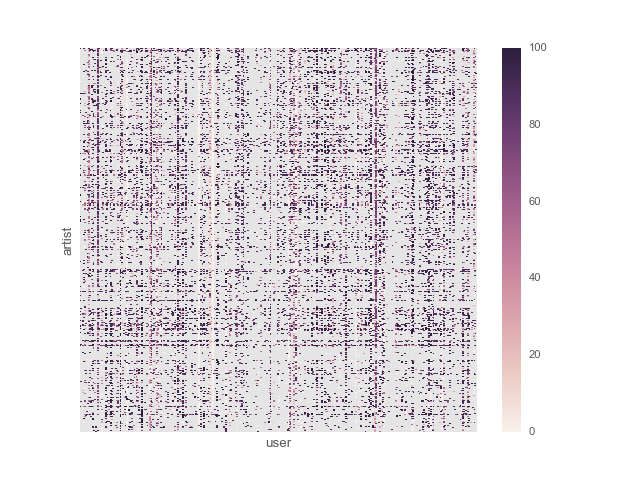

In [87]:
df_show = user_artist_df(30e3)
sns.heatmap(df_show, xticklabels=False, yticklabels=False);

### Top Artists

In [11]:
df_show = artist_mean_rate(30e3)
df = df_show.sort_values("weighted_mean_rate", ascending=False)[["artist"]][:10]
PrettyTable(df, tstyle= TableStyle(theme="theme1"), center=True)

artist
Linkin Park
Eminem
Missy Elliott
Evanescence
Red Hot Chili Peppers
Metallica
Nelly
Chingy
Sean Paul
Beyonce


In [84]:
IFrame("https://plot.ly/~ger94/84.embed", 800, 650)

## Training The Model

Find: $X, \theta$

$$
\theta^TX \approx Y
$$

Find: $X, \theta$

$$
\underset{\theta, X}{\min}J(\theta, X) \approx Y
$$

Find: $X, \theta$

$$
\underset{\theta, X}{\min}J(\theta, X) = (\theta^TX - Y)^2 \ ?
$$

Minimize sum of squared errors

**Goal**:

Find $\theta\in\mathbb{R}^{n_u\times n}$, $X\in\mathbb{R}^{n_m\times n}$ such that $\theta^TX\approx y$

$$
    \underset{\{\theta^{j}\}_{j = 1}^{n_u} \{x^{i}\}_{i = 1}^{n_m}}{\mathrm{min}} J(\theta^{(1)}, \ldots, \theta^{(n)}, x^{(1)}, \ldots, x^{(n)})
$$


**Cost Function**:

$$
    J(\theta^{(1)}, \ldots, \theta^{(n_u)}, x^{(1)}, \ldots, x^{(n_m)}) =  \frac{1}{2} \sum_{(i,j): r(i,j) = 1} \left( (\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right)^2 + \\ 
    \frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n}\left(x_k^{(i)}\right)^2 + 
    \frac{\lambda}{2}\sum_{i=1}^{n_u}\sum_{k=1}^{n}\left(\theta_k^{(i)}\right)^2
$$

How to minimize $J(\theta^{(1)}, \ldots, \theta^{(n)}, x^{(1)}, \ldots, x^{(n)})$ ?

Set $x^{(i)} \sim N(0,1)$

**Gradient Descent**: Derive, descend and find minimum!

$$
    \frac{\partial}{\partial x^{(i)}_k}J(\theta, X) = \sum_{(i,j): r(i,j) = 1} \left[ (\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right]\theta^{(j)}_k + \lambda x^{(i)}_k
$$

$$
    \frac{\partial}{\partial \theta^{(j)}_k}J(\theta, X) = \sum_{(i,j): r(i,j) = 1} \left[ (\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right]x^{(i)}_k + \lambda \theta^{(j)}_k
$$

iterate:

* $x^{(i)}_k = x^{(i)}_k - \alpha \frac{\partial}{\partial x^{(i)}_k}J(\theta, X)$
* $\theta^{(j)}_k = \theta^{(j)}_k - \alpha \frac{\partial}{\partial \theta^{(j)}_k}J(\theta, X)$

In [114]:
Image(url="gd.gif", width=600, height=600)

In [14]:
nrows = 500e3
df_show = artist_mean_rate(nrows)
train_df = user_artist_df(nrows=nrows)
cf_model = Collaborative_Filtering(500, train_df, 25, predict_txt)
cf_model.initalize_model()
cf_model.train(record_J=True, display=True, max_iter=500)
cf_model.final_cost

      fun: 18761070.840312205
 hess_inv: <9753500x9753500 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.48660713,  0.59506269, -0.10877772, ...,  0.75789172,
       -0.24752294,  0.22763567])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 528
      nit: 501
   status: 1
  success: False
        x: array([-0.73560735, -0.06471098, -0.05671739, ...,  0.2360635 ,
        0.48766897,  0.2185097 ])

In [57]:
with open("../data/trained_cf.pickle", "wb") as out:
    pickle.dump(cf_model.prediction, out)
    
with open("../data/Jcost_history.pickle", "wb") as out:
    pickle.dump(cf_model.J_cost_history, out)

In [36]:
with open("../data/trained_cf.pickle", "rb") as in_model:
    prediction = pickle.load(in_model)
    
with open("../data/Jcost_history.pickle", "rb") as in_model:
    J_cost_history = pickle.load(in_model)

![Raf Learnding](http://s2.quickmeme.com/img/1d/1d5741309ea65303b436ce736f0acca10c88b06552b42184650cb8b4119e036b.jpg)

<IPython.core.display.Javascript object>


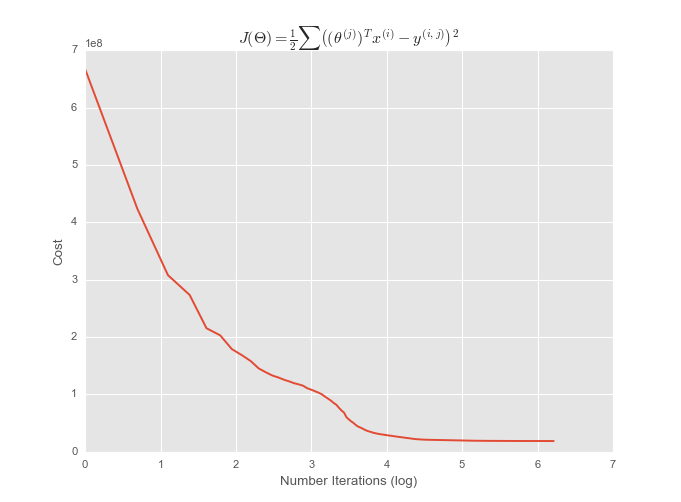

In [62]:
plt.plot(np.log(np.arange(len(J_cost_history))), J_cost_history)
plt.title(r"$J(\Theta) = \frac{1}{2} \sum \left( (\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right)^2$")
plt.xlabel("Number Iterations (log)")
plt.ylabel("Cost");

# Results

<IPython.core.display.Javascript object>


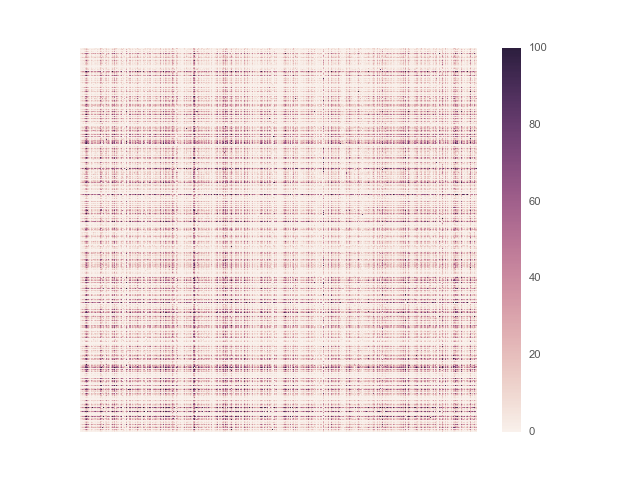

In [85]:
nsamp = 2000
tdata = pd.DataFrame(prediction).sample(nsamp, axis=0).sample(nsamp, axis=1)
sns.heatmap(tdata, xticklabels=False, yticklabels=False, vmin = 0, vmax = 100);

In [97]:
pred = pd.DataFrame(prediction[:,[-2, -1]], df_show.artist, columns=["ger", "carla"])
pred = pred[~pd.isnull(pred.index)]
pred[["carla"]].sort_values("carla", ascending = False)[:10]

,carla
artist,
Linkin Park,99.113452
Chingy,98.553744
Lil' Kim,98.512591
Janet Jackson,98.397524
Alanis Morissette,98.179913
Disturbed,98.065123
Faith Hill,97.881983
Green Day,88.481482
Tupac Shakur,83.485755


In [98]:
pred[["ger"]].sort_values("ger", ascending = False)[:10]

,ger
artist,
Alanis Morissette,98.271835
Lil' Kim,98.168819
Red Hot Chili Peppers,96.789455
Eminem,95.151570
Metallica,93.198492
Mary J. Blige,90.075317
Nirvana,89.267249
Mya,88.625979
Limp Bizkit,86.140591


In [86]:
IFrame("https://plot.ly/~ger94/90.embed", 800, 600)